In [1]:
import numpy as np  
from landaupy import landau
import matplotlib.pyplot as plt
from astropy import units as u 
# Choose directory where to save output plot 
outdir = './plots/'

# Define relevant physical constants   
m0 = 105.6583745 * u.MeV# MeV, muon mass
me = 0.510998950 * u.MeV # MeV, electron mass 

# # Define WCD cylinder tank dimensions  
h = 120 * u.cm #cm 
r = 180 * u.cm #cm 

# Look up material properties (water)
# https://pdg.lbl.gov/2024/AtomicNuclearProperties/HTML/water_liquid.html  

Z_A=0.55509 *u.mol / u.g #mol g^-1, atomic number Z over atomic mass mol g^-1 
rho=1 * u.g / u.cm**3 #g cm^-3, density of liquid water 
I=7.97e-5 * u.MeV #MeV, mean excitation energy

K=0.307075 * u.MeV * u.cm **2 / u.mol #MeV mol^−1 cm2

# Choose kinetic energy of the muon 
ek = 1000.* u.MeV # 1000 MeV = 1 GeV 


In [2]:
def _beta(ek):
    return np.sqrt(ek*ek + 2*ek*m0) / (ek+m0) 
def _gamma(ek): 
    return 1 / np.sqrt( 1 - _beta(ek)*_beta(ek) ) 

beta = _beta(ek)
gamma = _gamma(ek)

In [3]:
# Retrieve the function that computes energy losses of a single muon 
# step by step in the tank, extracting from a Landau distribution,
# and gives as an output the total energy deposited

def _eloss_step_landau(_beta,_gamma,_dx):
    
    # Width of the Landau 
    width =  K/2*Z_A*(_dx*rho/_beta**2) 
    
    # MPV of the Landau 
    mpv = width \
            *( np.log(2*me*_beta**2*_gamma**2/I) \
                +np.log(width/I) + 0.2
                         -_beta**2 )
    
    # Extract a value from the Landau distribution         
    _eloss = landau.sample(x_mpv=mpv.value, xi=width.value, n_samples=1) 
    
    return _eloss * u.MeV
         

In [4]:


# Now define a function that propagates the muon inside the tank for its full track lenght, 
# computing the energy loss at each step from a Landau distribution.
# Have the function return the total energy deposited. 
# This function will be iterated for multiple muons.    

def _eloss_tank_landau(start_ek,start_beta,start_gamma,_dx): 
    tmp_ek = start_ek
    tmp_beta = start_beta
    tmp_gamma = start_gamma 
    
    _tot_eloss_tank = 0. * u.MeV
    nsteps = int(h/_dx) 
    
    for i in range(nsteps): 

        _eloss =  _eloss_step_landau(tmp_beta,tmp_gamma,_dx)
        _tot_eloss_tank += _eloss

        # Update particle energy 
        tmp_ek = tmp_ek - _eloss  
        tmp_beta = _beta(ek)
        tmp_gamma = _gamma(ek) 
       

    return _tot_eloss_tank

In [5]:
# Choose step size and number of toy muons you want to launch 

dx = 10 * u.cm #cm 

# Choose number of toy muons to launch
 
n_iter = 1000
eloss_array = np.zeros(n_iter) 
eloss_array = eloss_array * u.MeV

# Initialize muon energy 
ek = 1000.* u.MeV # 1000 MeV = 1 GeV 
beta = _beta(ek)
gamma = _gamma(ek) 

for i in range(n_iter): 
    if(i%50 == 0):print('Launching muon #:',i)
    eloss_array[i] = _eloss_tank_landau(ek,beta,gamma,dx) 

Launching muon #: 0
Launching muon #: 50


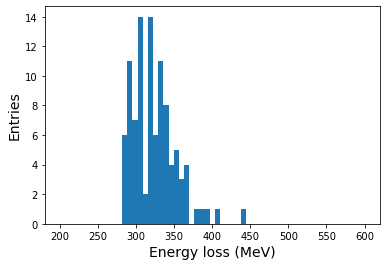

In [6]:
# Plot histogram of total energy loss for the toy muons 
plt.figure(1) 
#plt.yscale('log')
plt.xlabel('Energy loss (MeV)', size=14)
plt.ylabel('Entries', size=14)

hist = plt.hist(eloss_array.value ,bins = np.linspace(200.,600,60))
plt.savefig(outdir+'/toymu_'+str(n_iter)+'_eloss.svg',format = 'svg',bbox_inches='tight')
